In [1]:
import numpy as np
import os
import readdy
import pandas as pd
import networkx as nx  
###############################################################################
# PARAMETERS
###############################################################################

PARAMS = {
    # Simulation / integrator
    "box_size": [2000, 2000, 0.01],
    "repulsion_force_constant": 10.0,
    "bond_length": 10.0,
    "bond_force_constant": 100.0,
    "angle_force_constant": 10.0,
    "diffusion_constant": 0,
    "timestep": 0.5,
    "n_steps": 10000,
    "fusion_rate": 0,
    "fusion_radius": 10,
    "detection_rate": 7,

    # Branching
    "branch_chance": 0.15,
    "branch_length": 5,

    # Exclusion around bubble
    "bubble_exclusion_radius": 30.0,

    # Box potential
    "box_force_constant": 200.0,

    # Output / checkpointing
    "output_file": "confocal_HR_image_single_cell_15_mito_network_box_size_0.h5",
    "checkpoint_dir": "checkpoints_confocal_HR_image_single_cell_15/",
    "checkpoint_stride": 1000,
    "max_n_saves": 10,

    # Observables
    "observe_stride": 100,
    "trajectory_stride": 100,

    # Polylines scaling
    "scale": 0.55
}

###############################################################################
# HELPER FUNCTIONS
###############################################################################
def detection_rate_function(topology):
    """
    Returns a constant rate (DETECTION_RATE) at which we check the topology
    for 'fusion_detect_function' triggers.
    """
    edges = topology.get_graph().get_edges()
    return PARAMS["detection_rate"]


def fusion_detect_function(topology):
    """
    Custom structural reaction function that scans the topology graph 
    and changes particle types upon detecting specific fission/fusion criteria.
    """
    recipe = readdy.StructuralReactionRecipe(topology)
    graph = topology.get_graph()
    vertices = graph.get_vertices()

    processed_particles = set()

    for vertex in vertices:
        particle_index = vertex.particle_index
        if particle_index in processed_particles:
            continue

        current_type = topology.particle_type_of_vertex(vertex)
        neighbors = list(vertex.neighbors())
        num_connections = len(neighbors)

        changes = []         # (vertex_to_change, new_type)
        fusions_to_log = []  # store (pos1, pos2) to log if fusion occurs

        # Case 1: Two mito_node_1s, each with 2 connections -> both become mito_node_2
        if current_type != "mito_node_2" and num_connections == 2:
            changes.append((vertex, "mito_node_2"))
            for neighbor in neighbors:
                neighbor_index = neighbor.particle_index
                if neighbor_index in processed_particles:
                    continue

                neighbor_type = topology.particle_type_of_vertex(neighbor)
                neighbor_connections = len(list(neighbor.neighbors()))

                if neighbor_type != "mito_node_2" and neighbor_connections == 2:
                    changes.append((neighbor, "mito_node_2"))

                    processed_particles.add(particle_index)
                    processed_particles.add(neighbor_index)
                    pos_v = topology.position_of_vertex(vertex)
                    pos_n = topology.position_of_vertex(neighbor)
                    fusions_to_log.append((pos_v, pos_n))

        # Case 2: One mito_node_2 (3 connections) + One mito_node_1 (2 connections) 
        #         -> (mito_node_3, mito_node_2)
        elif current_type != "mito_node_3" and num_connections == 3:
            changes.append((vertex, "mito_node_3"))
            for neighbor in neighbors:
                neighbor_index = neighbor.particle_index
                if neighbor_index in processed_particles:
                    continue

                neighbor_type = topology.particle_type_of_vertex(neighbor)
                neighbor_connections = len(list(neighbor.neighbors()))

                if neighbor_type != "mito_node_2" and neighbor_connections == 2:
                    changes.append((neighbor, "mito_node_2"))

                    processed_particles.add(particle_index)
                    processed_particles.add(neighbor_index)


                    pos_v = topology.position_of_vertex(vertex)
                    pos_n = topology.position_of_vertex(neighbor)
                    fusions_to_log.append((pos_v, pos_n))

        # Apply the changes collected
        for vertex_to_change, new_type in changes:
            recipe.change_particle_type(vertex_to_change, new_type)
    return recipe

def create_readdy_system(params):
    """
    Create and configure the ReactionDiffusionSystem, including all species, 
    potentials, and topology force fields.
    """
    system = readdy.ReactionDiffusionSystem(box_size=params["box_size"])
    system.topologies.add_type("mitochondria")

    # Add topology species
    for species in ["mito_node_1", "mito_node_2", "mito_node_3"]:
        system.add_topology_species(species, params["diffusion_constant"])

    # Box potential
    system_origin = [
        -params["box_size"][0] / 2,
        -params["box_size"][1] / 2,
        -params["box_size"][2] / 2
    ]
    for ptype in ["mito_node_1", "mito_node_2", "mito_node_3"]:
        system.potentials.add_box(
            particle_type=ptype,
            force_constant=params["box_force_constant"],
            origin=system_origin,
            extent=params["box_size"]
        )

    # Pairwise harmonic repulsions
    pairs = [
        ("mito_node_1", "mito_node_1"), ("mito_node_1", "mito_node_2"),
        ("mito_node_1", "mito_node_3"), ("mito_node_2", "mito_node_2"),
        ("mito_node_2", "mito_node_3"), ("mito_node_3", "mito_node_3")
    ]
    for p1, p2 in pairs:
        system.potentials.add_harmonic_repulsion(
            p1, p2,
            force_constant=params["repulsion_force_constant"],
            interaction_distance=params["bond_length"]
        )

    # Harmonic bonds (all combinations of mito_node_x)
    node_types = ["mito_node_1", "mito_node_2", "mito_node_3"]
    for a in node_types:
        for b in node_types:
            system.topologies.configure_harmonic_bond(
                a, b,
                force_constant=params["bond_force_constant"],
                length=params["bond_length"]
            )

    # Harmonic angles
    angle_setups = [
        (("mito_node_1", "mito_node_2", "mito_node_2"), np.pi),
        (("mito_node_2", "mito_node_2", "mito_node_2"), np.pi),
        (("mito_node_1", "mito_node_3", "mito_node_2"), np.pi / 3),
        (("mito_node_2", "mito_node_3", "mito_node_2"), np.pi / 3),
        (("mito_node_3", "mito_node_3", "mito_node_3"), np.pi / 3),
    ]
    for triplet, angle in angle_setups:
        system.topologies.configure_harmonic_angle(
            *triplet,
            force_constant=params["angle_force_constant"],
            equilibrium_angle=angle
        )

    
    system.topologies.add_spatial_reaction(
        "fusion_1: mitochondria(mito_node_1) + mitochondria(mito_node_1) -> mitochondria(mito_node_1--mito_node_1)",
        rate=params["fusion_rate"], 
        radius=params["fusion_radius"]
    )

    system.topologies.add_spatial_reaction(
        "fusion_2: mitochondria(mito_node_1) + mitochondria(mito_node_2) -> mitochondria(mito_node_1--mito_node_2)",
        rate=params["fusion_rate"], 
        radius=params["fusion_radius"]
    )

    # Register the fusion structural reaction
    system.topologies.add_structural_reaction(
        "fusion_detect",
        "mitochondria",
        fusion_detect_function,
        detection_rate_function
    )

    return system


def run_simulation(simulation, params):
    """
    Set simulation parameters, enable checkpointing/observables,
    run the actual simulation, and convert to XYZ at the end.
    """
    simulation.integrator = "EulerBDIntegrator"
    simulation.reaction_handler = "Gillespie"
    simulation.output_file = params["output_file"]

    # Remove old file if present
    if os.path.exists(simulation.output_file):
        os.remove(simulation.output_file)

    # Observables
    sim_stride = params["observe_stride"]
    simulation.observe.topologies(stride=sim_stride)
    simulation.observe.particles(stride=sim_stride)
    simulation.record_trajectory(stride=params["trajectory_stride"])

    # Checkpoints
    simulation.make_checkpoints(
        stride=params["checkpoint_stride"],
        output_directory=params["checkpoint_dir"],
        max_n_saves=params["max_n_saves"]
    )
    simulation.list_checkpoint_files(params["checkpoint_dir"])

    # Performance
    simulation.kernel_configuration.n_threads = 8
    simulation.progress_output_stride = 10
    simulation.show_progress = True

    print("Running simulation...")
    simulation.run(n_steps=params["n_steps"], timestep=params["timestep"])

    # Post-processing
    trajectory = readdy.Trajectory(params["output_file"])
    trajectory.convert_to_xyz()
    print("Simulation complete!")


def build_topologies_from_csv(nodes_csv_path, edges_csv_path, simulation):
    """
    Build initial mitochondria complexes from two CSV files:
      nodes  : node_id,x_coord,y_coord
      edges  : source,target           (node IDs referring to the table above)

    One connected component  →  one topology.
    """
    # ------------------------------------------------------------------
    # 1.  Load data
    # ------------------------------------------------------------------
    df_nodes = pd.read_csv(nodes_csv_path)
    df_edges = pd.read_csv(edges_csv_path)

    # Convenience look‑ups
    coord = df_nodes.set_index("node_id")[["x_coord", "y_coord"]].to_dict("index")

    # ------------------------------------------------------------------
    # 2.  Build a pure NetworkX graph to find connected components
    # ------------------------------------------------------------------
    G = nx.Graph()
    G.add_nodes_from(coord.keys())
    G.add_edges_from(
        [(int(row.source), int(row.target))                # ensure ints
         for row in df_edges.itertuples(index=False)
         if row.source in coord and row.target in coord]  # skip dangling IDs
    )

    # ------------------------------------------------------------------
    # 3.  Iterate over connected components
    # ------------------------------------------------------------------
    for component in nx.connected_components(G):
        comp_nodes = list(component)

        # (a) Cartesian coordinates – z = 0 for a quasi‑2D sheet
        positions = np.array(
            [[coord[n]["x_coord"], coord[n]["y_coord"], 0.0] for n in comp_nodes],
            dtype=np.float64
        )

        # (b) All particles start as mito_node_1
        particle_types = ["mito_node_1"] * len(comp_nodes)

        # (c) Create the topology
        topo = simulation.add_topology(
            "mitochondria",
            particle_types=particle_types,
            positions=positions
        )

        # (d) Map global node_id → local vertex index inside this topology
        local_index = {node_id: i for i, node_id in enumerate(comp_nodes)}

        # (e) Add the bonds that belong to this component
        g = topo.get_graph()
        for u, v in G.subgraph(component).edges():
            g.add_edge(local_index[u], local_index[v])

        # Done – ReaDDy will automatically generate the harmonic bonds,
        # angles and dihedrals you configured earlier.



###############################################################################
# MAIN EXECUTION
###############################################################################

if __name__ == "__main__":
    # 1) Create system & simulation
    system = create_readdy_system(PARAMS)
    simulation = system.simulation(kernel="CPU")

    # 2) Build the initial topologies from the CSV file:
    #    each node becomes its own single-node topology.
    build_topologies_from_csv(
    nodes_csv_path="/home/mattliao/agent_based_model/skan/confocal_HR_image_single_cell_15_nodes.csv",
     edges_csv_path="/home/mattliao/agent_based_model/skan/confocal_HR_image_single_cell_15_edges.csv",
    simulation=simulation
)

    # 3) Run the simulation
    run_simulation(simulation, PARAMS)


Running simulation...
Configured kernel context with:
--------------------------------
 - kBT = 2.4361377615198827
 - periodic b.c. = (true, true, true)
 - box size = (2000, 2000, 0.01)
 - particle types:
     * Topology particle type "mito_node_3" with D=0
     * Topology particle type "mito_node_2" with D=0
     * Topology particle type "mito_node_1" with D=0
 - potentials of order 1:
     * for type "mito_node_3"
         * Harmonic Box inclusion potential with force constant 200 and parameters minimum vertex v0=(-1000,-1000,-0.005) and maximum vertex v1=(1000,1000,0.005).
     * for type "mito_node_2"
         * Harmonic Box inclusion potential with force constant 200 and parameters minimum vertex v0=(-1000,-1000,-0.005) and maximum vertex v1=(1000,1000,0.005).
     * for type "mito_node_1"
         * Harmonic Box inclusion potential with force constant 200 and parameters minimum vertex v0=(-1000,-1000,-0.005) and maximum vertex v1=(1000,1000,0.005).
 - potentials of order 2:
     

100%|██████████| 1000/1000 [00:08<00:00, 114.02it/s]


[2025-07-14 15:33:15] [info] Simulation completed
[2025-07-14 15:33:15] [warning] type mito_node_3 had explicitly no specified radius, using 1.0
Simulation complete!
[2025-07-14 15:33:15] [warning] type mito_node_2 had explicitly no specified radius, using 1.0
[2025-07-14 15:33:15] [warning] type mito_node_1 had explicitly no specified radius, using 1.0


In [2]:
trajectory = readdy.Trajectory(PARAMS["output_file"])
topology_time, topology_records = trajectory.read_observable_topologies()

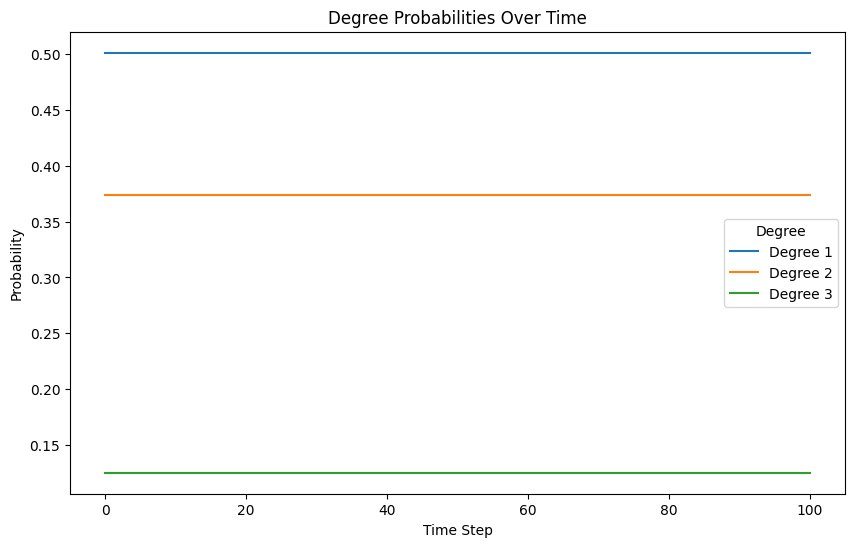

In [3]:
from collections import Counter
import matplotlib.pyplot as plt

# Define degrees to track
tracked_degrees = [1, 2, 3]
tracked_probabilities = {degree: [] for degree in tracked_degrees}
time_steps = []

# Loop through all time steps in topology_records
for t, topologies in enumerate(topology_records):
    degree_counts = []
    for topology in topologies:
        # Extract connections (edges) from the topology record
        edges = topology.edges  # Ensure this attribute exists in your data
        degrees = Counter()
        for edge in edges:
            # Increment the degree for each particle in the edge
            degrees[edge[0]] += 1
            degrees[edge[1]] += 1
        # Collect all degrees from this topology
        degree_counts.extend(degrees.values())
    
    # Count occurrences of each degree
    degree_distribution = Counter(degree_counts)
    total_nodes = sum(degree_distribution.values())
    
    # Calculate probabilities for tracked degrees
    for degree in tracked_degrees:
        count = degree_distribution.get(degree, 0)
        probability = count / total_nodes if total_nodes > 0 else 0
        tracked_probabilities[degree].append(probability)
    
    time_steps.append(t)

# Plotting probabilities over time
plt.figure(figsize=(10, 6))
for degree in tracked_degrees:
    plt.plot(time_steps, tracked_probabilities[degree], label=f'Degree {degree}')

plt.xlabel('Time Step')
plt.ylabel('Probability')
plt.title('Degree Probabilities Over Time')
plt.legend(title='Degree')
plt.show()
